In [374]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


video_path = "lap_full_voice.mp4"
gaze_path = "gaze_positions_old.npy"

# --- Load data ---
gaze_positions = np.load(gaze_path)  # shape (N, 2) with pixel coords (x, y)
print("Gaze shape:", gaze_positions.shape)

def get_video_info(path):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {path}")
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return fps, frame_count, w, h

video_fps, video_frames, frame_w, frame_h = get_video_info(video_path)
video_duration = video_frames / video_fps
print(f"Video FPS: {video_fps}, Frames: {video_frames}, Size: {frame_w}x{frame_h}, Duration: {video_duration:.1f}s")


Gaze shape: (224835, 2)
Video FPS: 25.0, Frames: 224835, Size: 1920x1080, Duration: 8993.4s


In [375]:
import os
from pathlib import Path
from PIL import Image, ImageDraw

def save_frame(frame_idx, out_dir="calibration"):
    """
    Save frame N from the video as calibration/N.jpg.
    
    - Creates the folder automatically if needed.
    - Uses the existing get_frame() to fetch the frame.
    """

    # Ensure output directory exists
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # Read frame (your get_frame function returns RGB ndarray)
    frame = get_frame(video_path, frame_idx)

    # Output path
    out_path = os.path.join(out_dir, f"{frame_idx}.jpg")

    # Save using PIL
    img = Image.fromarray(frame)
    img.save(out_path, quality=95)

    print(f"Saved frame {frame_idx} → {out_path}")


In [376]:
def get_frame(path, frame_idx):
    """Return frame at given index as RGB numpy array."""
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idx = max(0, min(frame_idx, total_frames - 1))

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if not ret or frame is None:
        raise ValueError(f"Could not read frame {frame_idx}")
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


def show_frame_with_gaze(frame_idx=None, time_sec=None, point_size=60):
    """
    Visualize a frame with its corresponding gaze.
    - gaze_positions.npy is assumed to be pixel coords (x, y).
    - One gaze sample per frame (same length as video_frames).
    """
    if frame_idx is None and time_sec is None:
        raise ValueError("Provide either frame_idx or time_sec.")

    # Determine frame index
    if time_sec is not None:
        frame_idx = int(round(time_sec * video_fps))
    # Clamp frame index
    frame_idx = max(0, min(frame_idx, video_frames - 1))
    time_sec = frame_idx / video_fps

    # Get video frame
    frame = get_frame(video_path, frame_idx)

    # Map to gaze index (1:1 with frame index here)
    gaze_idx = max(0, min(frame_idx, len(gaze_positions) - 1))
    gx, gy = gaze_positions[gaze_idx]

    # Clip gaze to image bounds (just in case)
    gx = np.clip(gx, 0, frame_w - 1)
    gy = np.clip(gy, 0, frame_h - 1)

    print(f"Frame {frame_idx} at t={time_sec:.2f}s, gaze_idx={gaze_idx}, gaze_px=({gx:.1f}, {gy:.1f})")

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.scatter([gx], [gy], s=point_size, marker='o')
    plt.title(f"Frame {frame_idx} (t = {time_sec:.2f}s)")
    plt.axis('off')
    plt.show()

def save_frame_by_time(time_sec, out_dir="calibration/set1"):
    """
    Save the video frame at <time_sec> seconds to calibration/<time>.jpg.
    
    - time_sec (float): timestamp in seconds
    - out_dir (str): output folder (default "calibration")
    """
    # Ensure output directory exists
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # Convert seconds → frame index
    frame_idx = int(round(time_sec * video_fps))

    # Protect bounds
    frame_idx = max(0, min(frame_idx, video_frames - 1))

    # Read frame (using your get_frame)
    frame = get_frame(video_path, frame_idx)

    # File name: use integer seconds unless you want decimals
    filename = f"{int(time_sec)}.jpg"
    out_path = os.path.join(out_dir, filename)

    # Save using PIL
    img = Image.fromarray(frame)
    img.save(out_path, quality=95)

    print(f"Saved frame at {time_sec}s (frame {frame_idx}) → {out_path}")


def save_frame_with_gaze_by_time(time_sec, out_dir="calibration/set2", radius=10):
    """
    Save the video frame at <time_sec> seconds with gaze overlaid
    as calibration/<time_sec_rounded>.jpg.

    - time_sec (float): timestamp in seconds
    - out_dir (str): output folder
    - radius (int): radius of the gaze dot
    """
    # Ensure output directory exists
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    # seconds -> frame index
    frame_idx = int(round(time_sec * video_fps))
    frame_idx = max(0, min(frame_idx, video_frames - 1))
    time_sec = frame_idx / video_fps  # synced time actually used

    # Get frame (RGB)
    frame = get_frame(video_path, frame_idx)

    # Map frame_idx -> gaze index (1:1 in your case)
    gaze_idx = max(0, min(frame_idx, len(gaze_positions) - 1))
    gx, gy = gaze_positions[gaze_idx]

    # Clip gaze to image bounds
    gx = int(np.clip(gx, 0, frame_w - 1))
    gy = int(np.clip(gy, 0, frame_h - 1))

    # Convert to PIL and draw gaze point
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    x0, y0 = gx - radius, gy - radius
    x1, y1 = gx + radius, gy + radius
    draw.ellipse((x0, y0, x1, y1), outline="red", width=3, fill="red")

    # File name: use integer seconds for simplicity
    filename = f"{int(time_sec)}.jpg"
    out_path = os.path.join(out_dir, filename)

    img.save(out_path, quality=95)
    print(f"Saved frame {frame_idx} at t={time_sec:.2f}s with gaze → {out_path}")


Frame 175850 at t=7034.00s, gaze_idx=175850, gaze_px=(685.0, 723.0)


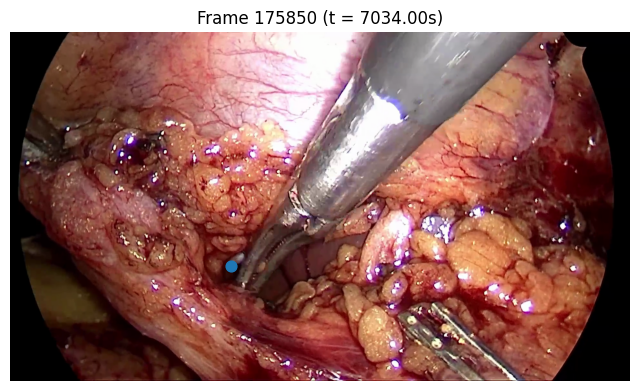

In [377]:
fid = 7034
show_frame_with_gaze(time_sec=fid)
#save_frame_by_time(fid)

In [378]:
save_frame_with_gaze_by_time(fid)

Saved frame 175850 at t=7034.00s with gaze → calibration/set2/7034.jpg


In [379]:
import os
import json
import numpy as np
from sklearn.linear_model import LinearRegression

calibration_dir = "calibration/set2"

gaze_positions = np.load("gaze_positions_old.npy")  # raw gaze (pixel coords)

X_raw = []  # model input: (gx, gy)
Y_gt  = []  # model output: (tx, ty)

for fname in os.listdir(calibration_dir):
    if not fname.endswith(".json"):
        continue

    json_path = os.path.join(calibration_dir, fname)

    # extract timestamp (assumes "<second>.json")
    second_str = fname.replace(".json", "")
    second = int(second_str)

    # read JSON
    with open(json_path, "r") as f:
        data = json.load(f)

    # get ground truth target point
    shape = data["shapes"][0]
    tx, ty = shape["points"][0]   # float pixel coords

    # map second -> frame index -> gaze index
    frame_idx = int(round(second * 25.0))  # because video_fps = 25
    gx, gy = gaze_positions[frame_idx]

    X_raw.append([gx, gy])
    Y_gt.append([tx, ty])

X_raw = np.array(X_raw)
Y_gt = np.array(Y_gt)

print("Loaded calibration dataset:")
print("X_raw shape:", X_raw.shape)
print("Y_gt  shape:", Y_gt.shape)

model = LinearRegression()
model.fit(X_raw, Y_gt)

print("Coefficients:")
print(model.coef_)
print("Intercept:")
print(model.intercept_)



Loaded calibration dataset:
X_raw shape: (13, 2)
Y_gt  shape: (13, 2)
Coefficients:
[[ 0.96245631 -0.06479598]
 [-0.05857611  0.86976178]]
Intercept:
[108.54512322 202.32905868]


In [380]:
test_sec = 5000
test_idx = int(test_sec * 25)

gx, gy = gaze_positions[test_idx]
tx, ty = model.predict([[gx, gy]])[0]

print(f"Calibrated gaze at t={test_sec}s → ({tx:.1f}, {ty:.1f})")


Calibrated gaze at t=5000s → (1459.5, 548.7)


In [381]:
# --- convert seconds to frames
start_sec = 4490
end_sec   = 8140

start_frame = int(start_sec * video_fps)
end_frame   = int(end_sec * video_fps)

segment = gaze_positions[start_frame:end_frame+1]

# --- fix NaNs by interpolation
def interpolate_nan_rows(arr):
    arr = arr.copy()
    for dim in range(arr.shape[1]):
        col = arr[:, dim]
        nans = np.isnan(col)
        if nans.any():
            not_nans = ~nans
            col[nans] = np.interp(
                np.flatnonzero(nans), 
                np.flatnonzero(not_nans),
                col[not_nans]
            )
        arr[:, dim] = col
    return arr

segment_fixed = interpolate_nan_rows(segment)

# --- apply model
calibrated_segment = model.predict(segment_fixed)
gaze_positions = np.load("gaze_positions.npy")
# --- update original array
gaze_positions[start_frame:end_frame+1] = calibrated_segment

print("Calibration applied successfully.")


Calibration applied successfully.


In [382]:
np.save("gaze_positions.npy", gaze_positions)
print("Saved updated gaze to gaze_positions.npy")

Saved updated gaze to gaze_positions.npy


Frame 175850 at t=7034.00s, gaze_idx=175850, gaze_px=(685.0, 723.0)


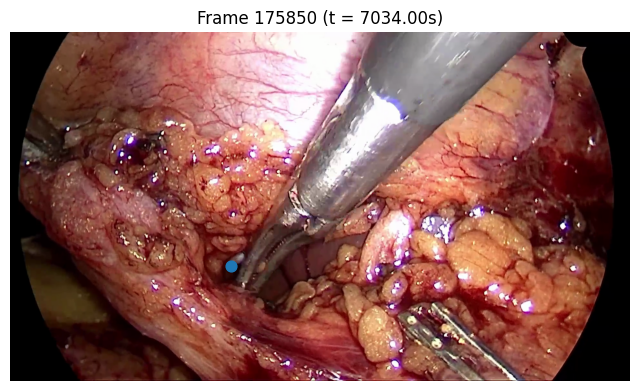

In [ ]:
fid = 7034
show_frame_with_gaze(time_sec=fid)
#save_frame_by_time(fid)